In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

### Generate a synthetic distribution and calculate S

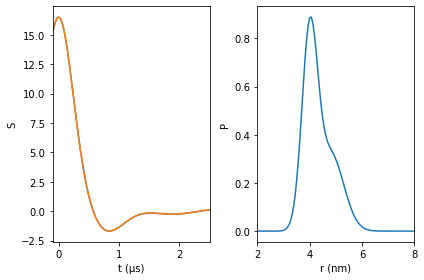

In [2]:
nr = 100
nt = 150

t = np.linspace(-0.1,2.5,nt)        # time axis, µs
r = np.linspace(2,8,nr)      # distance axis, ns

r0 = 4 
fwhm = 0.4 # parameters for three-Gaussian model
Ptrue = dive.dd_gauss(r,r0,fwhm)          # model distance distribution

param2 = [4, 0.3,0.6, 4.8, 0.5, 0.4] # parameters for three-Gaussian model
Ptrue = dl.dd_gauss2(r,param2)  

lam = 0.5
k = 0.1
V0 = 1                      # modulation depth

B = dive.bg_exp(t,k)         # background decay
K = dl.dipolarkernel(t,r,integralop=False)    # kernel matrix
sigma = 0.01

S0 = K@Ptrue
S = S0 + dl.whitegaussnoise(t,sigma,seed=0)

# Vexp = dive.deerTrace(K@P0,B,V0,lam) + dl.whitegaussnoise(t,sigma,seed=0)

fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, S0)
line1 = ax[0].plot(t, S)
line2 = ax[1].plot(r, Ptrue)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(r),max(r)], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

### Add custom sampling step for P

In [3]:
from pymc3.step_methods.arraystep import BlockedStep

class SampleRandP(BlockedStep):
    def __init__(self, var, delta, sigma, KtK, KtS, LtL, nr):
            self.vars = [var]
            self.var = var
            self.delta = delta
            self.sigma = sigma
            self.KtK = KtK
            self.KtS = KtS
            self.LtL = LtL
            self.nr = nr

    def step(self, point: dict):
        # sigma = np.exp(point[self.sigma.transformed.name])
        sigma = self.sigma
        tau = 1/(sigma**2)
        delta = np.exp(point[self.delta.transformed.name])
       
        new = point.copy()
        new[self.var.name] = dive.randP(delta,tau,self.KtK,self.KtS,self.LtL,self.nr)

        return new

In [4]:
KtK = np.matmul(np.transpose(K),K)
KtS = np.matmul(np.transpose(K),S)

rn = np.linspace(1,nr,nr) 
L = dl.regoperator(rn,1)
LtL = np.matmul(np.transpose(L),L)

1000000.0

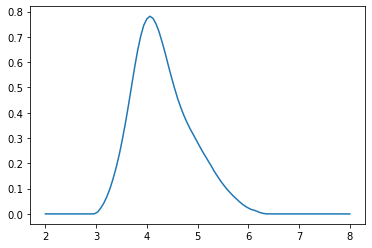

In [5]:
alpha = 10
tau = 1/sigma**2
delta = (alpha**2)*tau
display(delta)

Pdraw = dive.randP(delta,tau,KtK,KtS,LtL,nr)

plt.plot(r,Pdraw)



### Setup model

In [6]:
# if true:
#     delta_init = 1^2*tau
#     %P_init needs to be a randomized draw so that norm(LP) is about the right size.
#     P_init = randP(delta_init,tauKtK,tauKtS,LtL,nt);
#     a0 = 1;
#     b0 = (1+nt/2)/delta_init - 0.5*norm(L*P_init)^2;
# else:
a0 = 0.01
b0 = 1e-6

# tau = 1/(sigma**2)
# alpha = comes from regularization solution
# delta_init = alpha^2*tau
# P_init = randP(delta_init,tauKTK,tauKtS,LtL,nr)

KtK = np.matmul(np.transpose(K),K)
KtS = np.matmul(np.transpose(K),S)

rn = np.linspace(1,nr,nr) 
L = dl.regoperator(rn,1)
LtL = np.matmul(np.transpose(L),L)

# These parameters are only used for the definition of P0 as a pymc3 variable
Pmap = Ptrue

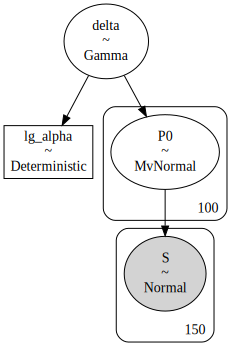

In [7]:
with pm.Model() as model:
    # Noise
    # sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    sigma = 0.01
    # tau = pm.Deterministic('tau',1/(sigma**2))
    tau = 1/sigma**2

    # Regularization parameter
    # a = a0 + nr/2
    # b = b0 + (1/2)*T.sum(pm.math.dot(L,P0)**2)
    a = a0
    b = b0
    delta = pm.Gamma('delta', alpha=a, beta=b)
    lg_alpha = pm.Deterministic('lg_alpha',np.log10(np.sqrt(delta/tau)))
    
    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)
    P0 = pm.MvNormal("P0", mu=Pmap, chol = C_L, shape = nr)    
    # P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    # Time domain
    # V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)
    Smodel = pm.math.dot(K,P0)

    # Likelihood
    # pm.Normal('S',mu = V0*Smodel, sigma = sigma, observed = S)
    pm.Normal('S',mu = Smodel, sigma = sigma, observed = S)

pm.model_to_graphviz(model)

### Run sampler

In [8]:
with model:
    step_P0 = SampleRandP(P0, delta, sigma, KtK, KtS, LtL, nr)  
    trace = pm.sample(step = step_P0, chains=4, cores=1, draws=8000, tune=4000,return_inferencedata=False)

Sequential sampling (4 chains in 1 job)
CompoundStep
>SampleRandP: [P0]
>NUTS: [delta]


Sampling 4 chains for 4_000 tune and 8_000 draw iterations (16_000 + 32_000 draws total) took 1322 seconds.
The acceptance probability does not match the target. It is 0.9137419092531495, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8858872073927951, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.31150792007746264, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


### Analysis

In [9]:
dive.summary(trace, model, S, t, r, Ptrue = Pmap)

KeyError: 'Unknown variable P'

### Same but more noise

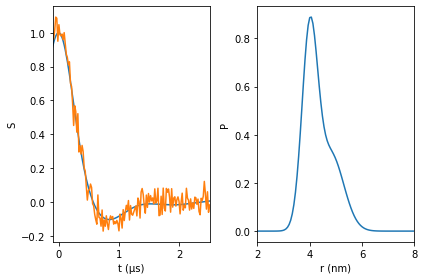

In [4]:
param2 = [4, 0.3,0.6, 4.8, 0.5, 0.4] # parameters for three-Gaussian model
P0 = dl.dd_gauss2(r,param2)  

sigma = 0.05

S = S0 + dl.whitegaussnoise(t,sigma,seed=0)

fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, S0)
line1 = ax[0].plot(t, S)
line2 = ax[1].plot(r, P0)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(r),max(r)], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

In [5]:
# if true:
#     delta_init = 1^2*tau
#     %P_init needs to be a randomized draw so that norm(LP) is about the right size.
#     P_init = randP(delta_init,tauKtK,tauKtS,LtL,nt);
#     a0 = 1;
#     b0 = (1+nt/2)/delta_init - 0.5*norm(L*P_init)^2;
# else:
a0 = 0.01
b0 = 1e-6

# tau = 1/(sigma**2)
# alpha = comes from regularization solution
# delta_init = alpha^2*tau
# P_init = randP(delta_init,tauKTK,tauKtS,LtL,nr)

KtK = np.matmul(np.transpose(K),K)
KtS = np.matmul(np.transpose(K),S)

rn = np.linspace(1,nr,nr) 
L = dl.regoperator(rn,1)
LtL = np.matmul(np.transpose(L),L)

# These parameters are only used for the definition of P0 as a pymc3 variable
Pmap = P0

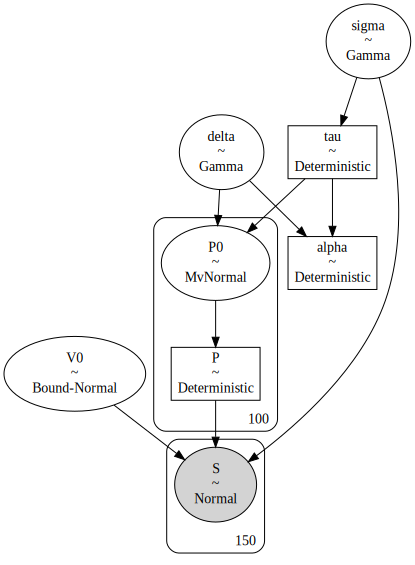

In [6]:
with pm.Model() as model:
    # Noise
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter
    # a = a0 + nr/2
    # b = b0 + (1/2)*T.sum(pm.math.dot(L,P0)**2)
    a = a0
    b = b0
    delta = pm.Gamma('delta', alpha=a, beta=b)
    alpha = pm.Deterministic('alpha',np.sqrt(delta/tau))
    
    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)
    P0 = pm.MvNormal("P0", mu=Pmap, chol = C_L, shape = nr)    
    P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    # Time domain
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)
    Smodel = pm.math.dot(K,P)

    # Likelihood
    pm.Normal('S',mu = V0*Smodel, sigma = sigma, observed = S)

pm.model_to_graphviz(model)

In [7]:
with model:
    step_P0 = SampleRandP(P0, delta, sigma, KtK, KtS, LtL, nr)  
    noisy_trace = pm.sample(step = step_P0, chains=1, cores=1, draws=4000, tune=2000,return_inferencedata=False)

Sequential sampling (1 chains in 1 job)
CompoundStep
>SampleRandP: [P0]
>NUTS: [V0, delta, sigma]


Sampling 1 chain for 2_000 tune and 4_000 draw iterations (2_000 + 4_000 draws total) took 147 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V₀,1.068,0.020,1.032,1.108,0.000,0.000,3336.0,2768.0,NaN
σ,0.056,0.004,0.048,0.064,0.000,0.000,2629.0,2502.0,NaN
τ,321.065,48.901,234.550,414.488,0.951,0.678,2629.0,2502.0,NaN
δ,699.546,187.240,387.863,1061.392,5.272,3.729,1214.0,1988.0,NaN
alpha,1.475,0.223,1.064,1.895,0.006,0.004,1215.0,2327.0,NaN


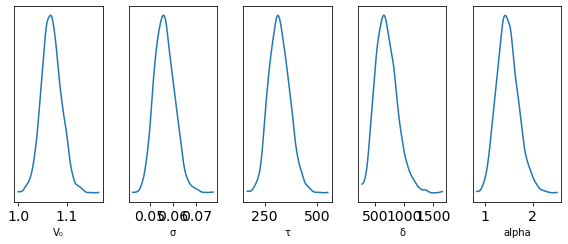

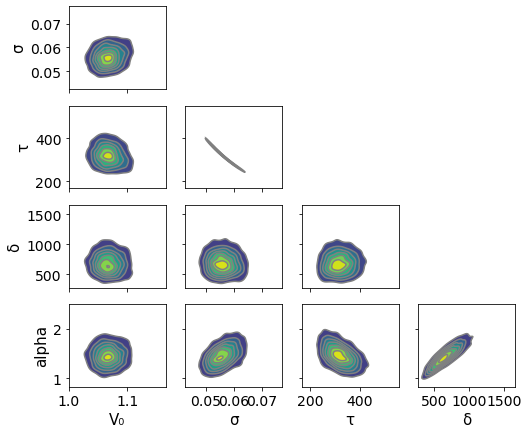

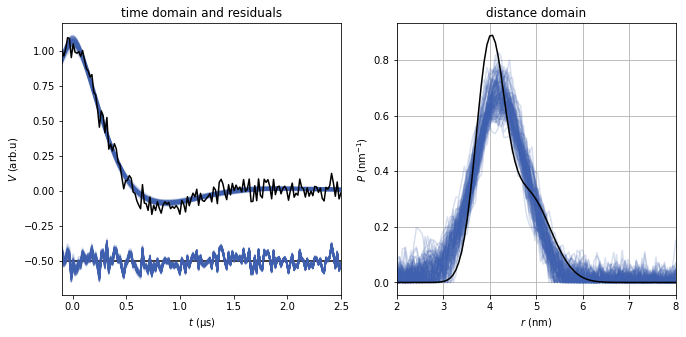

In [8]:
dive.summary(noisy_trace, model, S, t, r, Ptrue = Pmap)

## Bimodal

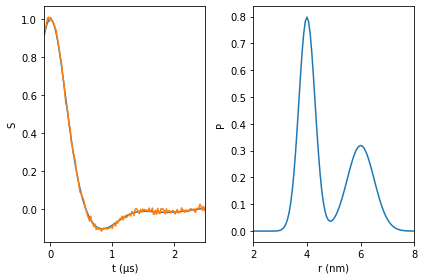

In [4]:
param2 = [4, 0.3,0.6, 6, 0.5, 0.4] # parameters for three-Gaussian model
P0 = dl.dd_gauss2(r,param2)  

sigma = 0.01

S = S0 + dl.whitegaussnoise(t,sigma,seed=0)

fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, S0)
line1 = ax[0].plot(t, S)
line2 = ax[1].plot(r, P0)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(r),max(r)], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

In [5]:
# if true:
#     delta_init = 1^2*tau
#     %P_init needs to be a randomized draw so that norm(LP) is about the right size.
#     P_init = randP(delta_init,tauKtK,tauKtS,LtL,nt);
#     a0 = 1;
#     b0 = (1+nt/2)/delta_init - 0.5*norm(L*P_init)^2;
# else:
a0 = 0.01
b0 = 1e-6

# tau = 1/(sigma**2)
# alpha = comes from regularization solution
# delta_init = alpha^2*tau
# P_init = randP(delta_init,tauKTK,tauKtS,LtL,nr)

KtK = np.matmul(np.transpose(K),K)
KtS = np.matmul(np.transpose(K),S)

rn = np.linspace(1,nr,nr) 
L = dl.regoperator(rn,1)
LtL = np.matmul(np.transpose(L),L)

# These parameters are only used for the definition of P0 as a pymc3 variable
Pmap = P0

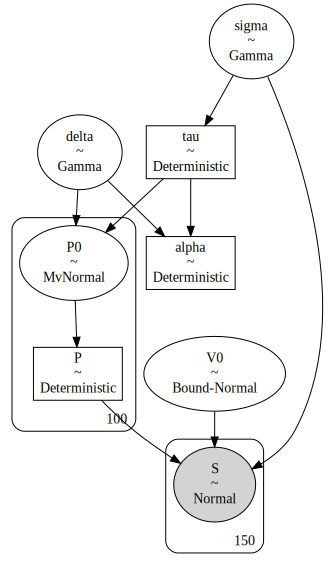

In [6]:
with pm.Model() as model:
    # Noise
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter
    # a = a0 + nr/2
    # b = b0 + (1/2)*T.sum(pm.math.dot(L,P0)**2)
    a = a0
    b = b0
    delta = pm.Gamma('delta', alpha=a, beta=b)
    alpha = pm.Deterministic('alpha',np.sqrt(delta/tau))
    
    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)
    P0 = pm.MvNormal("P0", mu=Pmap, chol = C_L, shape = nr)    
    P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    # Time domain
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)
    Smodel = pm.math.dot(K,P)

    # Likelihood
    pm.Normal('S',mu = V0*Smodel, sigma = sigma, observed = S)

pm.model_to_graphviz(model)

In [7]:
model.test_point

{'sigma_log__': array(-1.04982212),
 'delta_log__': array(9.21034037),
 'P0': array([1.78224350e-10, 6.71444590e-10, 2.42845390e-09, 8.43190506e-09,
        2.81058985e-08, 8.99383712e-08, 2.76291960e-07, 8.14830177e-07,
        2.30696790e-06, 6.27034681e-06, 1.63612741e-05, 4.09843655e-05,
        9.85586714e-05, 2.27534360e-04, 5.04283386e-04, 1.07294597e-03,
        2.19157614e-03, 4.29744965e-03, 8.08985161e-03, 1.46199485e-02,
        2.53645213e-02, 4.22457521e-02, 6.75483880e-02, 1.03686574e-01,
        1.52793787e-01, 2.16154639e-01, 2.93561580e-01, 3.82745259e-01,
        4.79067401e-01, 5.75652015e-01, 6.64049947e-01, 7.35393803e-01,
        7.81843418e-01, 7.98001943e-01, 7.81950565e-01, 7.35628551e-01,
        6.64455723e-01, 5.76300348e-01, 4.80065805e-01, 3.84248069e-01,
        2.95783861e-01, 2.19389190e-01, 1.57431026e-01, 1.10236741e-01,
        7.66650822e-02, 5.47492428e-02, 4.22627213e-02, 3.71243422e-02,
        3.76232081e-02, 4.24898775e-02, 5.08615180e-02, 6.2

In [ ]:
with model:
    step_P0 = SampleRandP(P0, delta, sigma, KtK, KtS, LtL, nr)  
    bimodal = pm.sample(step = step_P0, chains=1, cores=1, draws=4000, tune=2000,return_inferencedata=False, start = {'V0': 1,'sigma': 0.01})

In [ ]:
dive.summary(bimodal, model, S, t, r, Ptrue = Pmap)